# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). I have used only subset of this data for the analysis results.

In [1]:
# Extract data
!tar chvfz notebook.tar.gz *

Sparkify-zh.ipynb
Sparkify.ipynb
mini_sparkify_event_data.json
notebook.tar.gz
tar: notebook.tar.gz: file changed as we read it
spark-warehouse/


In [2]:
!ls

mini_sparkify_event_data.json  Sparkify.ipynb	  spark-warehouse
notebook.tar.gz		       Sparkify-zh.ipynb


### Packages

In [3]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.functions import col, lit, udf, isnan, count, when, desc, sort_array, asc, avg, lag, floor
from pyspark.sql.types import IntegerType, DateType
from pyspark.sql.window import Window
from pyspark.sql.functions import sum as Fsum
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import MinMaxScaler #used because won't distort binary vars
from pyspark.sql.types import DoubleType
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import datetime
from pyspark.ml import Pipeline 
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, LinearSVC, GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns


from pyspark.ml.feature import RegexTokenizer, CountVectorizer, \
    IDF, StringIndexer, VectorAssembler, Normalizer, StandardScaler



In [4]:
# create a Spark session
spark = SparkSession.builder \
    .master("local") \
    .appName("Identify Features") \
    .getOrCreate()

df = spark.read.json('mini_sparkify_event_data.json')

# Print schema for future reference
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [5]:
df.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')

In [6]:
df.persist()

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]

In [7]:
# Converted the spark dataframe through pandas
dfp = df.toPandas()
dfp.head()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1.538332e+12,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1.538332e+12,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30


In [8]:
#check missing values - userId, sessionId does not have any missing values
dfp.isnull().sum()

artist           58392
auth                 0
firstName         8346
gender            8346
itemInSession        0
lastName          8346
length           58392
level                0
location          8346
method               0
page                 0
registration      8346
sessionId            0
song             58392
status               0
ts                   0
userAgent         8346
userId               0
dtype: int64

In [9]:
#display datatypes
dfp.dtypes

artist            object
auth              object
firstName         object
gender            object
itemInSession      int64
lastName          object
length           float64
level             object
location          object
method            object
page              object
registration     float64
sessionId          int64
song              object
status             int64
ts                 int64
userAgent         object
userId            object
dtype: object

In [10]:
# Explore the values of some categoric columns
dfp.artist.unique(), dfp.auth.unique(), dfp.firstName.unique(), dfp.lastName.unique(), dfp.level.unique(), dfp.location.unique()

(array(['Martha Tilston', 'Five Iron Frenzy', 'Adam Lambert', ...,
        'PROFANE OMEN', 'Gabriel Romero', '28 Days'], dtype=object),
 array(['Logged In', 'Logged Out', 'Cancelled', 'Guest'], dtype=object),
 array(['Colin', 'Micah', 'Ashlynn', 'Alexi', None, 'Warren', 'Alex',
        'Ainsley', 'Zyonna', 'Faigy', 'Madison', 'Grant', 'Anika',
        'Isobella', 'Payton', 'Christian', 'Teagan', 'Kael', 'Daelin',
        'Giovanni', 'Jaleel', 'Panav', 'Carly', 'Elizabeth', 'Riley',
        'Deegan', 'Ethan', 'Molly', 'Lucero', 'Bryson', 'Nicole', 'Kaylenn',
        'Joseph', 'Oliver', 'Annabella', 'Ellen', 'Madelyn', 'Sawyer',
        'Chase', 'Spencer', 'Sebastian', 'Dillyn', 'Lina', 'Calvin',
        'Erick', 'Autumn', 'Miracle', 'Kaleb', 'Chayse', 'Parker',
        'Adelaida', 'Lily', 'Sadie', 'Aurora', 'Freedom', 'Genesis',
        'William', 'Davis', 'Nikolas', 'Peyton', 'Nithya', 'Adriel',
        'Brayden', 'Jayden', 'Alexander', 'Alexandria', 'Destiny', 'Nathan',
        'Jeffe

In [11]:
# Explore the values of some categoric columns
dfp.level.unique(), dfp.method.unique(), dfp.page.unique(), dfp.status.unique(), dfp.gender.unique(), dfp.auth.unique()

(array(['paid', 'free'], dtype=object),
 array(['PUT', 'GET'], dtype=object),
 array(['NextSong', 'Add to Playlist', 'Roll Advert', 'Thumbs Up',
        'Downgrade', 'Thumbs Down', 'Home', 'Logout', 'Help', 'Login',
        'Upgrade', 'Add Friend', 'About', 'Settings', 'Submit Upgrade',
        'Submit Downgrade', 'Error', 'Save Settings', 'Cancel',
        'Cancellation Confirmation', 'Register', 'Submit Registration'], dtype=object),
 array([200, 307, 404]),
 array(['M', 'F', None], dtype=object),
 array(['Logged In', 'Logged Out', 'Cancelled', 'Guest'], dtype=object))

In [12]:
dfp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 286500 entries, 0 to 286499
Data columns (total 18 columns):
artist           228108 non-null object
auth             286500 non-null object
firstName        278154 non-null object
gender           278154 non-null object
itemInSession    286500 non-null int64
lastName         278154 non-null object
length           228108 non-null float64
level            286500 non-null object
location         278154 non-null object
method           286500 non-null object
page             286500 non-null object
registration     278154 non-null float64
sessionId        286500 non-null int64
song             228108 non-null object
status           286500 non-null int64
ts               286500 non-null int64
userAgent        278154 non-null object
userId           286500 non-null object
dtypes: float64(2), int64(4), object(12)
memory usage: 39.3+ MB


In [13]:
dfp[dfp.userId == ''].shape

(8346, 18)

In [14]:
dfp[dfp.userId == '']['userId'].count()

8346

In [15]:
# Using Spark commands
df.filter(df.sessionId == '').count()

0

In [16]:
# drop the missing user id
df = df.filter(df.userId != '')
# Check - this  SHOULD be 0
df.filter(df.userId == '').count()

0

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

In [17]:
# Let's know the number of users in this dataset and the number of pages and sessions
# redifine the pandas dataframe
dfp = df.toPandas()

# Let's know the number of users in this dataset and the number of pages and sessions
print('the number of users are {}, the nubmer of pages are {}, the number of sessions are {}'.format(dfp['userId'].nunique(), dfp['page'].nunique(), dfp['sessionId'].nunique()))

the number of users are 225, the nubmer of pages are 19, the number of sessions are 2312



### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

In [18]:
# Before defining churn - let us see what values exist in page feature

df.select("page").dropDuplicates().show()

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
|            Settings|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+



In [19]:
# Churn is a label for the user with Cancellation Confirmation
flag_cancellation_event = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())

In [20]:
# apply to the dataframe
df = df.withColumn("churn", flag_cancellation_event("page"))
#Define window bounds
windowval = Window.partitionBy("userId").rangeBetween(Window.unboundedPreceding, Window.unboundedFollowing)
# Applying the window
df = df.withColumn("churn", Fsum("churn").over(windowval))

In [21]:
#check the churn record
df.filter(df.churn==1).take(1)

[Row(artist="Christopher O'Riley", auth='Logged In', firstName='Mason', gender='M', itemInSession=0, lastName='Hart', length=337.91955, level='free', location='Corpus Christi, TX', method='PUT', page='NextSong', registration=1533157139000, sessionId=174, song='paranoid android', status=200, ts=1539317144000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId='125', churn=1)]

In [22]:
#check the records of spark format
df.take(3)

[Row(artist='Sleeping With Sirens', auth='Logged In', firstName='Darianna', gender='F', itemInSession=0, lastName='Carpenter', length=202.97098, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='NextSong', registration=1538016340000, sessionId=31, song='Captain Tyin Knots VS Mr Walkway (No Way)', status=200, ts=1539003534000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='100010', churn=0),
 Row(artist='Francesca Battistelli', auth='Logged In', firstName='Darianna', gender='F', itemInSession=1, lastName='Carpenter', length=196.54485, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='NextSong', registration=1538016340000, sessionId=31, song='Beautiful_ Beautiful (Album)', status=200, ts=1539003736000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0

In [23]:
# Again define pandas df for better view
dfp = df.toPandas()

In [24]:
dfp.head(3)

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId,churn
0,Sleeping With Sirens,Logged In,Darianna,F,0,Carpenter,202.97098,free,"Bridgeport-Stamford-Norwalk, CT",PUT,NextSong,1538016340000,31,Captain Tyin Knots VS Mr Walkway (No Way),200,1539003534000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,0
1,Francesca Battistelli,Logged In,Darianna,F,1,Carpenter,196.54485,free,"Bridgeport-Stamford-Norwalk, CT",PUT,NextSong,1538016340000,31,Beautiful_ Beautiful (Album),200,1539003736000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,0
2,Brutha,Logged In,Darianna,F,2,Carpenter,263.13098,free,"Bridgeport-Stamford-Norwalk, CT",PUT,NextSong,1538016340000,31,She's Gone,200,1539003932000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,0


In [25]:
dfp['method'].value_counts()

PUT    257818
GET     20336
Name: method, dtype: int64

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [26]:
# behavior for users who stayed vs users who churned
dfp.drop_duplicates(subset='userId').groupby(['churn'])['userId'].count()

churn
0    173
1     52
Name: userId, dtype: int64

In [27]:
#Lets use spark command
df.dropDuplicates(['userId']).groupby(['churn']).count().show()

+-----+-----+
|churn|count|
+-----+-----+
|    0|  173|
|    1|   52|
+-----+-----+



In [28]:
# Exploring user status by paid status level - using Spark
df.dropDuplicates(['userId', 'level']).groupby(['churn', 'level']).count().show()

+-----+-----+-----+
|churn|level|count|
+-----+-----+-----+
|    1| paid|   36|
|    1| free|   46|
|    0| free|  149|
|    0| paid|  129|
+-----+-----+-----+



In [29]:
# Exploring user status by gender - using Spark
df.dropDuplicates(['userId', 'gender']).groupby(['churn', 'gender']).count().show()

+-----+------+-----+
|churn|gender|count|
+-----+------+-----+
|    0|     F|   84|
|    1|     M|   32|
|    1|     F|   20|
|    0|     M|   89|
+-----+------+-----+



In [30]:
gender_df = df.dropDuplicates(['userId', 'gender']).groupby(['churn', 'gender']).count()
gender_df = gender_df.toPandas()

In [31]:
gender_df.head()

,churn,gender,count
0,0,F,84
1,1,M,32
2,1,F,20
3,0,M,89


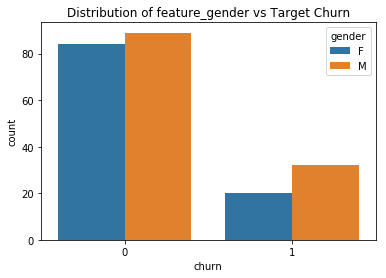

In [32]:
plt.title("Distribution of feature_gender vs Target Churn");
sns.barplot(x="churn", y="count", hue='gender',data=gender_df);
plt.show();

In [33]:
# Exploring user status by gender - using Spark
df.dropDuplicates(['userId', 'status']).groupby(['churn', 'status']).count().show()

+-----+------+-----+
|churn|status|count|
+-----+------+-----+
|    0|   307|  171|
|    1|   307|   52|
|    1|   404|   22|
|    0|   200|  173|
|    1|   200|   52|
|    0|   404|   95|
+-----+------+-----+



In [34]:
user_status_df = df.dropDuplicates(['userId', 'status']).groupby(['churn', 'status']).count()
user_status_df = user_status_df.toPandas()

In [35]:
user_status_df.head()

,churn,status,count
0,0,307,171
1,1,307,52
2,1,404,22
3,0,200,173
4,1,200,52


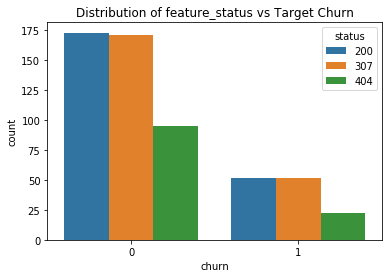

In [36]:
plt.title("Distribution of feature_status vs Target Churn");
sns.barplot(x="churn", y="count", hue='status',data=user_status_df);
plt.show();

In [37]:
#number of songs played by both the groups
df_songs = df.where(df.song !='null').groupby(['churn','userId']) \
    .agg(count(df.song).alias('SongsPlayed')).orderBy('churn').toPandas()

In [38]:
df_songs.head()

,churn,userId,SongsPlayed
0,0,100010,275
1,0,200002,387
2,0,124,4079
3,0,7,150
4,0,15,1914


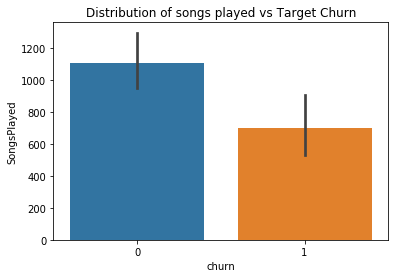

In [39]:
plt.title("Distribution of songs played vs Target Churn");
sns.barplot(x="churn", y="SongsPlayed", data=df_songs);
plt.show();

[]

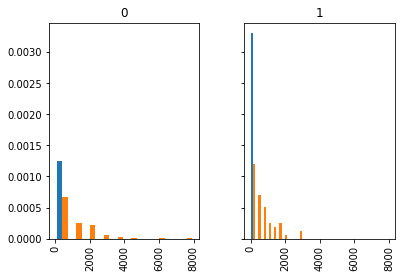

In [40]:
df_songs.hist(['SongsPlayed'], by='churn', sharex=True, sharey=True,density=1)
plt.plot()

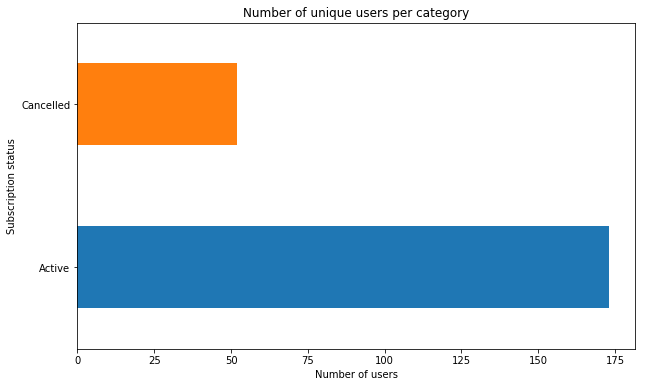

In [41]:
def plot_graph(subset, group, labels, x_title="Number of users", y_title="Subscription status"):
    ax = dfp.drop_duplicates(subset=subset).groupby(
                                group)['userId'].count().plot(
                                kind='barh', figsize=(10,6), 
                                title='Number of unique users per category');
    ax.set_xlabel(x_title);
    ax.set_yticklabels(labels, rotation=0)
    ax.set_ylabel(y_title);

# Test    
plot_graph(['userId'], ['churn'], ['Active', 'Cancelled'])

We see a huge number of cancelation, about 25% of the users canceled!

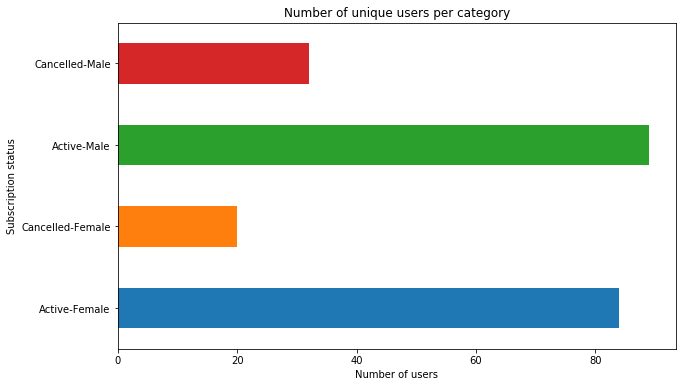

In [42]:
plot_graph(['userId', 'gender'], 
               ['gender', 'churn'], 
               ['Active-Female', 'Cancelled-Female', 'Active-Male', 'Cancelled-Male'])

The active males are more than females, and the canceling males are higher than females too. Seems like males tend to cancel more than females.

#### Features based on Time

In [43]:
# Defining user functions to get hour, day, month, and weekday of cancellation

get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).hour)
get_day = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).day)
get_month = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).month)

# Source https://stackoverflow.com/questions/38928919/how-to-get-the-weekday-from-day-of-month-using-pyspark
get_weekday = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime('%w'))

In [44]:
# Adding columns to the dataframe
funcs = {'hour':get_hour, 'day':get_day, 'month':get_month, 'week_day':get_weekday}
for label, func in funcs.items():
    df = df.withColumn(label, func(df.ts))
    df.take(1)
    print(f'Column {label} added successfully.')

Column hour added successfully.
Column day added successfully.
Column month added successfully.
Column week_day added successfully.


In [45]:
df.take(2)

[Row(artist='Sleeping With Sirens', auth='Logged In', firstName='Darianna', gender='F', itemInSession=0, lastName='Carpenter', length=202.97098, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='NextSong', registration=1538016340000, sessionId=31, song='Captain Tyin Knots VS Mr Walkway (No Way)', status=200, ts=1539003534000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='100010', churn=0, hour='12', day='8', month='10', week_day='1'),
 Row(artist='Francesca Battistelli', auth='Logged In', firstName='Darianna', gender='F', itemInSession=1, lastName='Carpenter', length=196.54485, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='NextSong', registration=1538016340000, sessionId=31, song='Beautiful_ Beautiful (Album)', status=200, ts=1539003736000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleW

In [46]:
# to help in better plotting and visuals
dfp = df.toPandas()
dfp.head(2)

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,...,song,status,ts,userAgent,userId,churn,hour,day,month,week_day
0,Sleeping With Sirens,Logged In,Darianna,F,0,Carpenter,202.97098,free,"Bridgeport-Stamford-Norwalk, CT",PUT,...,Captain Tyin Knots VS Mr Walkway (No Way),200,1539003534000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,0,12,8,10,1
1,Francesca Battistelli,Logged In,Darianna,F,1,Carpenter,196.54485,free,"Bridgeport-Stamford-Norwalk, CT",PUT,...,Beautiful_ Beautiful (Album),200,1539003736000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,0,13,8,10,1


In [47]:
songs_in_hour = df.filter(df.page == "NextSong").groupby([df.hour, df.churn]).count().orderBy(df.hour.cast("float"))

In [48]:
songs_in_hour.show()

+----+-----+-----+
|hour|churn|count|
+----+-----+-----+
|   0|    0| 7527|
|   0|    1| 1535|
|   1|    0| 7035|
|   1|    1| 1353|
|   2|    1| 1322|
|   2|    0| 7014|
|   3|    1| 1292|
|   3|    0| 7063|
|   4|    1| 1233|
|   4|    0| 6914|
|   5|    0| 6960|
|   5|    1| 1218|
|   6|    0| 6836|
|   6|    1| 1218|
|   7|    1| 1218|
|   7|    0| 6873|
|   8|    0| 7023|
|   8|    1| 1230|
|   9|    0| 7268|
|   9|    1| 1230|
+----+-----+-----+
only showing top 20 rows



In [49]:
songs_in_hour_pd = songs_in_hour.toPandas()
songs_in_hour_pd.hour = pd.to_numeric(songs_in_hour_pd.hour)

In [50]:
songs_in_hour_pd.head()

,hour,churn,count
0,0,1,1535
1,0,0,7527
2,1,0,7035
3,1,1,1353
4,2,1,1322


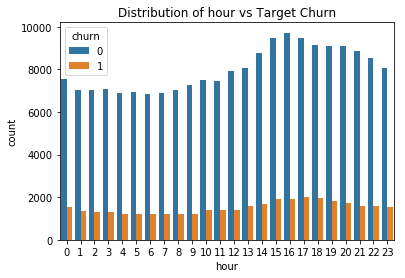

In [51]:
plt.title("Distribution of hour vs Target Churn");
sns.barplot(x="hour", y="count", hue='churn',data=songs_in_hour_pd);
plt.figure(figsize=(20,10))
plt.show();

In [52]:
df.take(1)

[Row(artist='Sleeping With Sirens', auth='Logged In', firstName='Darianna', gender='F', itemInSession=0, lastName='Carpenter', length=202.97098, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='NextSong', registration=1538016340000, sessionId=31, song='Captain Tyin Knots VS Mr Walkway (No Way)', status=200, ts=1539003534000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='100010', churn=0, hour='12', day='8', month='10', week_day='1')]

In [ ]:
#number of songs played by both the groups
df_hour_songs = df.where(df.song !='null').groupby(['churn','hour']) \
    .agg(count(df.song).alias('SongsPlayed')).orderBy('churn').toPandas()
df_hour_songs.head()

In [ ]:
df.take(1)

In [ ]:
df.createOrReplaceTempView('df_table')

In [ ]:
spark.sql("""
          SELECT
              churn,
              count(distinct userId)
            FROM
                df_table
            GROUP BY
                churn
            """).show()

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [57]:
#let us what features - we can add to final model
df.select("page").dropDuplicates().show()

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
|            Settings|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+



#### submit downgrade Feature

In [58]:
#submit downgrade and thumbs down might be important parameters if we think that the user might churn
users_with_downgrade = spark.sql("select distinct userId from df_table where page = 'Submit Downgrade'")
users_with_downgrade = users_with_downgrade.toPandas()['userId'].values

In [59]:
has_sub_downgrade = udf(lambda user: 1 if user in users_with_downgrade else 0, IntegerType())
spark.udf.register('has_sub_downgrade', has_sub_downgrade)

<function __main__.<lambda>(user)>

In [60]:
df = spark.sql("""
    SELECT
        *,
        has_sub_downgrade(userId) as hasSubDowngrade
    FROM
        df_table
    """)

In [61]:
df.createOrReplaceTempView('df_table')

In [62]:
downgrade_feat = spark.sql("""
    SELECT
        DISTINCT userId,
        hasSubDowngrade,
        churn
    FROM
        df_table
    """)

In [63]:
downgrade_feat

DataFrame[userId: string, hasSubDowngrade: int, churn: bigint]

In [64]:
downgrade_feat.take(1)

[Row(userId='300017', hasSubDowngrade=0, churn=0)]

In [65]:
downgrade_feat.createOrReplaceTempView('downgrade_feat_table')

In [66]:
spark.sql("select churn, sum(hasSubDowngrade)/count(distinct userId) from downgrade_feat_table group by churn").show()

+-----+-----------------------------------------------------------------------------------------------+
|churn|(CAST(sum(CAST(hasSubDowngrade AS BIGINT)) AS DOUBLE) / CAST(count(DISTINCT userId) AS DOUBLE))|
+-----+-----------------------------------------------------------------------------------------------+
|    0|                                                                            0.23121387283236994|
|    1|                                                                            0.17307692307692307|
+-----+-----------------------------------------------------------------------------------------------+



Intersting observation is that the users with churn status = 1 has lesser count % in downgrading as compared to churn status = 0. Hence we will not include this feature.

#### Usage time of the User

In [67]:
usage_time_feature = spark.sql("""
    SELECT
        DISTINCT userId,
        sum(nvl(length, 0)) as usageTime
    FROM
        df_table
    WHERE
        page = 'NextSong'
    GROUP BY
        userId
    """)

In [68]:
usage_time_feature.createOrReplaceTempView('usage_time_feature_table')

In [69]:
usage_time = spark.sql("""
    SELECT
        churn,
        sum(length)/count(distinct userId) as usageTime
    FROM
        df_table
    WHERE
        page = 'NextSong'
    GROUP BY
        churn
    """)

In [70]:
usage_time.show()

+-----+------------------+
|churn|         usageTime|
+-----+------------------+
|    0|276166.93746780336|
|    1| 174014.2685513462|
+-----+------------------+



We can observe that we have high usage time for non-churn users - hence we can include this feature to our final model

#### Feature Thumps Up

 We assume that the churn user will have lesser Thumps up

In [71]:
thumps_up_feature = spark.sql("""
    SELECT
        DISTINCT userId,
        count(1) as Count_ThumpsUp
    FROM
        df_table
    WHERE
        page = 'Thumbs Up'
    GROUP BY
        userId
    """)

thumps_up_feature.createOrReplaceTempView('thumps_up_feature_table')

In [72]:
thumps_up_feature.show(5)

+------+--------------+
|userId|Count_ThumpsUp|
+------+--------------+
|100010|            17|
|200002|            21|
|    51|           100|
|   124|           171|
|     7|             7|
+------+--------------+
only showing top 5 rows



In [73]:
df.take(1)

[Row(artist='Sleeping With Sirens', auth='Logged In', firstName='Darianna', gender='F', itemInSession=0, lastName='Carpenter', length=202.97098, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='NextSong', registration=1538016340000, sessionId=31, song='Captain Tyin Knots VS Mr Walkway (No Way)', status=200, ts=1539003534000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='100010', churn=0, hour='12', day='8', month='10', week_day='1', hasSubDowngrade=0)]

#### Feature thumbs down

In [74]:
thumps_down_feature = spark.sql("""
    SELECT
        DISTINCT userId,
        count(1) as Count_ThumpsDown
    FROM
        df_table
    WHERE
        page = 'Thumbs Down'
    GROUP BY
        userId
    """)

thumps_down_feature.createOrReplaceTempView('thumps_down_feature_table')

In [75]:
thumps_down_feature.show(5)

+------+----------------+
|userId|Count_ThumpsDown|
+------+----------------+
|100010|               5|
|200002|               6|
|    51|              21|
|   124|              41|
|     7|               1|
+------+----------------+
only showing top 5 rows



#### Feature - Help

Assuming that the user with churn asks for less help

In [76]:
spark.sql("""
    SELECT
        churn,
        count(1)/count(DISTINCT userId)
    FROM
        df_table
    WHERE
        page = 'Help'
    GROUP BY
        churn
    """).show()

+-----+-------------------------------------------------------------------+
|churn|(CAST(count(1) AS DOUBLE) / CAST(count(DISTINCT userId) AS DOUBLE))|
+-----+-------------------------------------------------------------------+
|    0|                                                  8.154362416107382|
|    1|                                                  5.558139534883721|
+-----+-------------------------------------------------------------------+



It is clear that - users with churn status have asked for less help

In [77]:
feature_help = spark.sql("""
    SELECT
        DISTINCT userId,
        count(1) as n_help
    FROM
        df_table
    WHERE
        page = 'Help'
    GROUP BY
        userId
    """)

feature_help.createOrReplaceTempView('feature_help_table')

#### Add to playlist Feature

Here we assume that users with less churn status will be more on adding to 'Add to Playlist'

In [78]:
feature_add_to_playlist =spark.sql("""
    SELECT
        churn,
        count(1)/count(DISTINCT userId)
    FROM
        df_table
    WHERE
        page = 'Add to Playlist'
    GROUP BY
        churn
    """)

In [79]:
feature_add_to_playlist.createOrReplaceTempView('feature_add_to_playlist_table')

In [80]:
feature_add_to_playlist.show()

+-----+-------------------------------------------------------------------+
|churn|(CAST(count(1) AS DOUBLE) / CAST(count(DISTINCT userId) AS DOUBLE))|
+-----+-------------------------------------------------------------------+
|    0|                                                  33.26060606060606|
|    1|                                                              20.76|
+-----+-------------------------------------------------------------------+



#### Paid length user Feature

We can check the feature - Paid users will not get churn

In [81]:
spark.sql("""
    SELECT
        churn,
        count(1)/count(DISTINCT userId)
    FROM
        df_table
    WHERE
        level = 'paid'
    GROUP BY
        churn
    """).show()

+-----+-------------------------------------------------------------------+
|churn|(CAST(count(1) AS DOUBLE) / CAST(count(DISTINCT userId) AS DOUBLE))|
+-----+-------------------------------------------------------------------+
|    0|                                                 1472.5348837209303|
|    1|                                                  902.1111111111111|
+-----+-------------------------------------------------------------------+



In [82]:
feature_length_paid = spark.sql("""
    SELECT
        DISTINCT userId,
        sum(nvl(length, 0)) as lengthAsPaid
    FROM
        df_table
    WHERE
        level = 'paid'
    GROUP BY
        userId
    """)

feature_length_paid.createOrReplaceTempView('feature_length_paid_table')

### Combine All Features

Total usage time of the app per user

In [83]:
usage_time_attribute = spark.sql("""
    SELECT
        DISTINCT d.userId,
        usageTime
    FROM
        df_table as d
    LEFT JOIN
        usage_time_feature_table as f
    ON
        d.userId=f.userId
    """)

usage_time_attribute.createOrReplaceTempView('usage_time_attribute_table')

Shows how many thumbs Up a particular user has given

In [84]:
thumps_up_feature = spark.sql("""
    SELECT
        DISTINCT d.userId,
        Count_ThumpsUp
    FROM
        df_table as d
    LEFT JOIN
        thumps_up_feature_table as f
    ON
        d.userId=f.userId
    """)

thumps_up_feature.createOrReplaceTempView('thumps_up_feature_table')

Shows how many thumbs down a particular user has given 

In [85]:
thumps_down_feature = spark.sql("""
    SELECT
        DISTINCT d.userId,
        Count_ThumpsDown
    FROM
        df_table as d
    LEFT JOIN
        thumps_down_feature_table as f
    ON
        d.userId=f.userId
    """)

thumps_down_feature.createOrReplaceTempView('thumps_down_feature_table')

Shows the user taking help from others

In [86]:
feature_help = spark.sql("""
    SELECT
        DISTINCT d.userId,
        n_help
    FROM
        df_table as d
    LEFT JOIN
        feature_help_table as f
    ON
        d.userId=f.userId
    """)

feature_help.createOrReplaceTempView('feature_help_table')

Shows the paid status length of each User

In [87]:
feature_length_paid = spark.sql("""
    SELECT
        DISTINCT d.userId,
        lengthAsPaid
    FROM
        df_table as d
    LEFT JOIN
        feature_length_paid_table as f
    ON
        d.userId=f.userId
    """)

feature_length_paid.createOrReplaceTempView('feature_length_paid_table')

## Final combined file

In [88]:
features = spark.sql("""
    SELECT
        usage.userId,       
        paid.lengthAsPaid,
        n_help,
        Count_ThumpsUp,
        usageTime,
        Count_ThumpsDown
    FROM
        usage_time_attribute_table as usage    
    LEFT JOIN
        feature_length_paid_table as paid
    ON
        paid.userId = usage.userId 
    LEFT JOIN
        feature_help_table as help
    ON
        help.userId=paid.userId 
    LEFT JOIN
        thumps_up_feature_table as thumpsup
    ON
        thumpsup.userId=help.userId
    LEFT JOIN
        thumps_down_feature_table as thumpsdown
    ON
        thumpsdown.userId=help.userId       
    """)
features.createOrReplaceTempView('features_table')

In [89]:
features.show()

+------+------------------+------+--------------+------------------+----------------+
|userId|      lengthAsPaid|n_help|Count_ThumpsUp|         usageTime|Count_ThumpsDown|
+------+------------------+------+--------------+------------------+----------------+
|100010|              null|     2|            17| 66940.89735000003|               5|
|200002| 72934.26395999998|     2|            21| 94008.87593999993|               6|
|   125|              null|  null|          null|2089.1131000000005|            null|
|   124|1012312.0927899999|    23|           171|1012312.0927899999|              41|
|    51| 523275.8428000004|    12|           100| 523275.8428000004|              21|
|     7|              null|     1|             7| 38034.08710000002|               1|
|    15|477307.60581000015|     8|            81|477307.60581000015|              14|
|    54| 600432.4393900005|    17|           163| 711344.9195400011|              29|
|   155|       174342.9883|     9|            58|     

Let us prepare the final features dataset where we fill all the null values with 0 and final model input features are captured.

In [90]:
features = spark.sql("""
    SELECT
        nvl(userId,0) as userId,
        nvl(lengthAsPaid,0) as lengthAsPaid,
        nvl(Count_ThumpsUp,0) as Count_ThumpsUp,
        nvl(n_help,0) as n_help,
     
        nvl(usageTime,0) as usageTime,
        nvl(Count_ThumpsDown,0) as Count_ThumpsDown
    FROM
        features_table
    """)

features.createOrReplaceTempView('features_table')

In [91]:
features.show()

+------+------------------+--------------+------+------------------+----------------+
|userId|      lengthAsPaid|Count_ThumpsUp|n_help|         usageTime|Count_ThumpsDown|
+------+------------------+--------------+------+------------------+----------------+
|100010|               0.0|            17|     2| 66940.89735000003|               5|
|200002| 72934.26395999998|            21|     2| 94008.87593999993|               6|
|   125|               0.0|             0|     0|2089.1131000000005|               0|
|   124|1012312.0927899999|           171|    23|1012312.0927899999|              41|
|    51| 523275.8428000004|           100|    12| 523275.8428000004|              21|
|     7|               0.0|             7|     1| 38034.08710000002|               1|
|    15|477307.60581000015|            81|     8|477307.60581000015|              14|
|    54| 600432.4393900005|           163|    17| 711344.9195400011|              29|
|   155|       174342.9883|            58|     9|     

Let us include the target variable

In [92]:
targets = spark.sql("""
    SELECT
        distinct userId,
        churn as label
    FROM
        df_table """
         )

targets.createOrReplaceTempView('targets_table')

In [93]:
features = spark.sql("""
    SELECT
        f.*,
        CAST(t.label AS INT) as label
    FROM
        features_table as f,
        targets_table as t
    WHERE
        f.userId=t.userId
        """)

features.createOrReplaceTempView('features_table')

# Modeling

Here let us split the data into train and valid/test. Let us test some machine learning methods that are covered in the tutorials. As the dataset is small and the target variable is of soem imbalance - it is better to evaluate with f1 score as metric. 


Here we need to scale the data - because we observe that  all the column values are with different range values. Hence it is better to scale the data and send as inputs to the model

In [94]:
assembler = VectorAssembler(inputCols=[ "lengthAsPaid","Count_ThumpsUp","n_help","usageTime"], outputCol="inputAllFeatures")
scaler = Normalizer(inputCol="inputAllFeatures", outputCol="ScaledAllFeatures")

Let us apply the Logistic regression and GBT classifier method for our model output results.

In [95]:
model_lr = LogisticRegression(featuresCol="ScaledAllFeatures", labelCol="label", maxIter=20, regParam=0.01)
pipeline_lr = Pipeline(stages=[assembler, scaler, model_lr])

In [96]:
train, test = features.randomSplit([0.8, 0.2])

In [97]:
model_lr_fitted = pipeline_lr.fit(train)

In [98]:
def model_output(model, test_data, metric = 'f1'):
    """ Evaluate a machine learning model's performance 
    
        Input: 
            model(object) - trained model or pipeline object
            metric - the metric used to measure performance
            data - test data on which performance measurement should be performed
        Output:
            score
    """
    
    evaluator = MulticlassClassificationEvaluator(metricName = metric)
    predictions = model.transform(test_data)
    
    # calcualte score
    score = evaluator.evaluate(predictions)
    
    return score

In [99]:
model_output(model_lr_fitted, test)

0.6805555555555557

### Improvement in Score

For checking for any improvements in score - let us check with gradient boosting classifier tree as an algorithm

In [100]:
model_gbt = GBTClassifier(featuresCol="ScaledAllFeatures", labelCol="label")
pipeline_gbt = Pipeline(stages=[assembler, scaler, model_gbt])
model_gbt_fitted = pipeline_gbt.fit(train)

In [101]:
model_output(model_gbt_fitted, test)

0.7178175618073316

GBT classifier had showed improvement in scores